In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import (
    RandomForestRegressor,
    VotingRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
)
import pycaret.regression as pyr


In [88]:
from user_pkg import user_func as uf
import importlib

importlib.reload(uf)


<module 'user_pkg.user_func' from 'c:\\EXAM_PYTHON\\KDT-mini_project-07\\이현길\\user_pkg\\user_func.py'>

In [89]:
pubg_file = "../DATA/train_V2.csv"
# pubg_test_file = '../DATA/test_V2.csv'
# pubg_test_target_file = '../DATA/sample_submission_V2.csv'


In [90]:
pubgDF_ori = pd.read_csv(pubg_file)
# pubg_test_featureDF = pd.read_csv(pubg_test_file)
# pubg_test_targetDF = pd.read_csv(pubg_test_target_file)
# pubg_testDF = pd.concat([pubg_test_featureDF, pubg_test_targetDF], axis=1)


In [91]:
pubgDF_ori.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [92]:
drop_features_object = ["Id", "groupId", "matchId"]
drop_features_low_connection = [
    "killPoints",
    "kills",
    "maxPlace",
    "numGroups",
    "rideDistance",
    "roadKills",
    "swimDistance",
    "vehicleDestroys",
]
drop_features_replace = ["rankPoints", "winPoints"]


In [93]:
pubgDF_pre1 = pubgDF_ori.drop(drop_features_object, axis=1)
pubgDF_pre1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  matchType        object 
 13  maxPlace         int64  
 14  numGroups        int64  
 15  rankPoints       int64  
 16  revives          int64  
 17  rideDistance     float64
 18  roadKills        int64  
 19  swimDistance     float64
 20  teamKills        int64  
 21  vehicleDestroys  int64  
 22  walkDistance     float64
 23  weaponsAcquired  int64  
 24  winPoints        int64  
 25  winPlacePerc     float64
dtypes: float64(6), int64(19), object(1)
memory

In [94]:
pubgDF_pre2 = pubgDF_pre1.drop(drop_features_low_connection, axis=1)
pubgDF_pre2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killStreaks      int64  
 8   longestKill      float64
 9   matchDuration    int64  
 10  matchType        object 
 11  rankPoints       int64  
 12  revives          int64  
 13  teamKills        int64  
 14  walkDistance     float64
 15  weaponsAcquired  int64  
 16  winPoints        int64  
 17  winPlacePerc     float64
dtypes: float64(4), int64(13), object(1)
memory usage: 610.7+ MB


In [95]:
pubgDF_pre2[drop_features_replace]


,rankPoints,winPoints
0,-1,1466
1,1484,0
2,1491,0
3,1408,0
4,1560,0
...,...,...
4446961,-1,1507
4446962,1501,0
4446963,1500,0
4446964,1418,0


In [96]:
pubgDF_pre2[drop_features_replace][
    (pubgDF_pre2["rankPoints"] != -1)
    & (pubgDF_pre2["rankPoints"] != 0)
    & (pubgDF_pre2["winPoints"] != 0)
]


,rankPoints,winPoints


In [97]:
winRankPoints = pubgDF_pre2["rankPoints"].replace(-1, 0) + pubgDF_pre2["winPoints"]
winRankPoints


0          1466
1          1484
2          1491
3          1408
4          1560
           ... 
4446961    1507
4446962    1501
4446963    1500
4446964    1418
4446965    1590
Length: 4446966, dtype: int64

In [98]:
pubgDF_pre3 = pd.concat(
    [
        pubgDF_pre2.drop(drop_features_replace + ["winPlacePerc"], axis=1),
        winRankPoints.rename("winRankPoints"),
        pubgDF_pre2["winPlacePerc"],
    ],
    axis=1,
)


In [99]:
pubgDF_pre3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killStreaks      int64  
 8   longestKill      float64
 9   matchDuration    int64  
 10  matchType        object 
 11  revives          int64  
 12  teamKills        int64  
 13  walkDistance     float64
 14  weaponsAcquired  int64  
 15  winRankPoints    int64  
 16  winPlacePerc     float64
dtypes: float64(4), int64(12), object(1)
memory usage: 576.8+ MB


In [100]:
pubgDF_duo = pubgDF_pre3[pubgDF_pre3["matchType"].isin(["duo"])].reset_index(drop=True)
pubgDF_duo = pubgDF_duo.drop(["matchType"], axis=1)


In [101]:
pubgDF_duo_fpp = pubgDF_pre3[pubgDF_pre3["matchType"].isin(["duo-fpp"])].reset_index(
    drop=True
)
pubgDF_duo_fpp = pubgDF_duo_fpp.drop(["matchType"], axis=1)


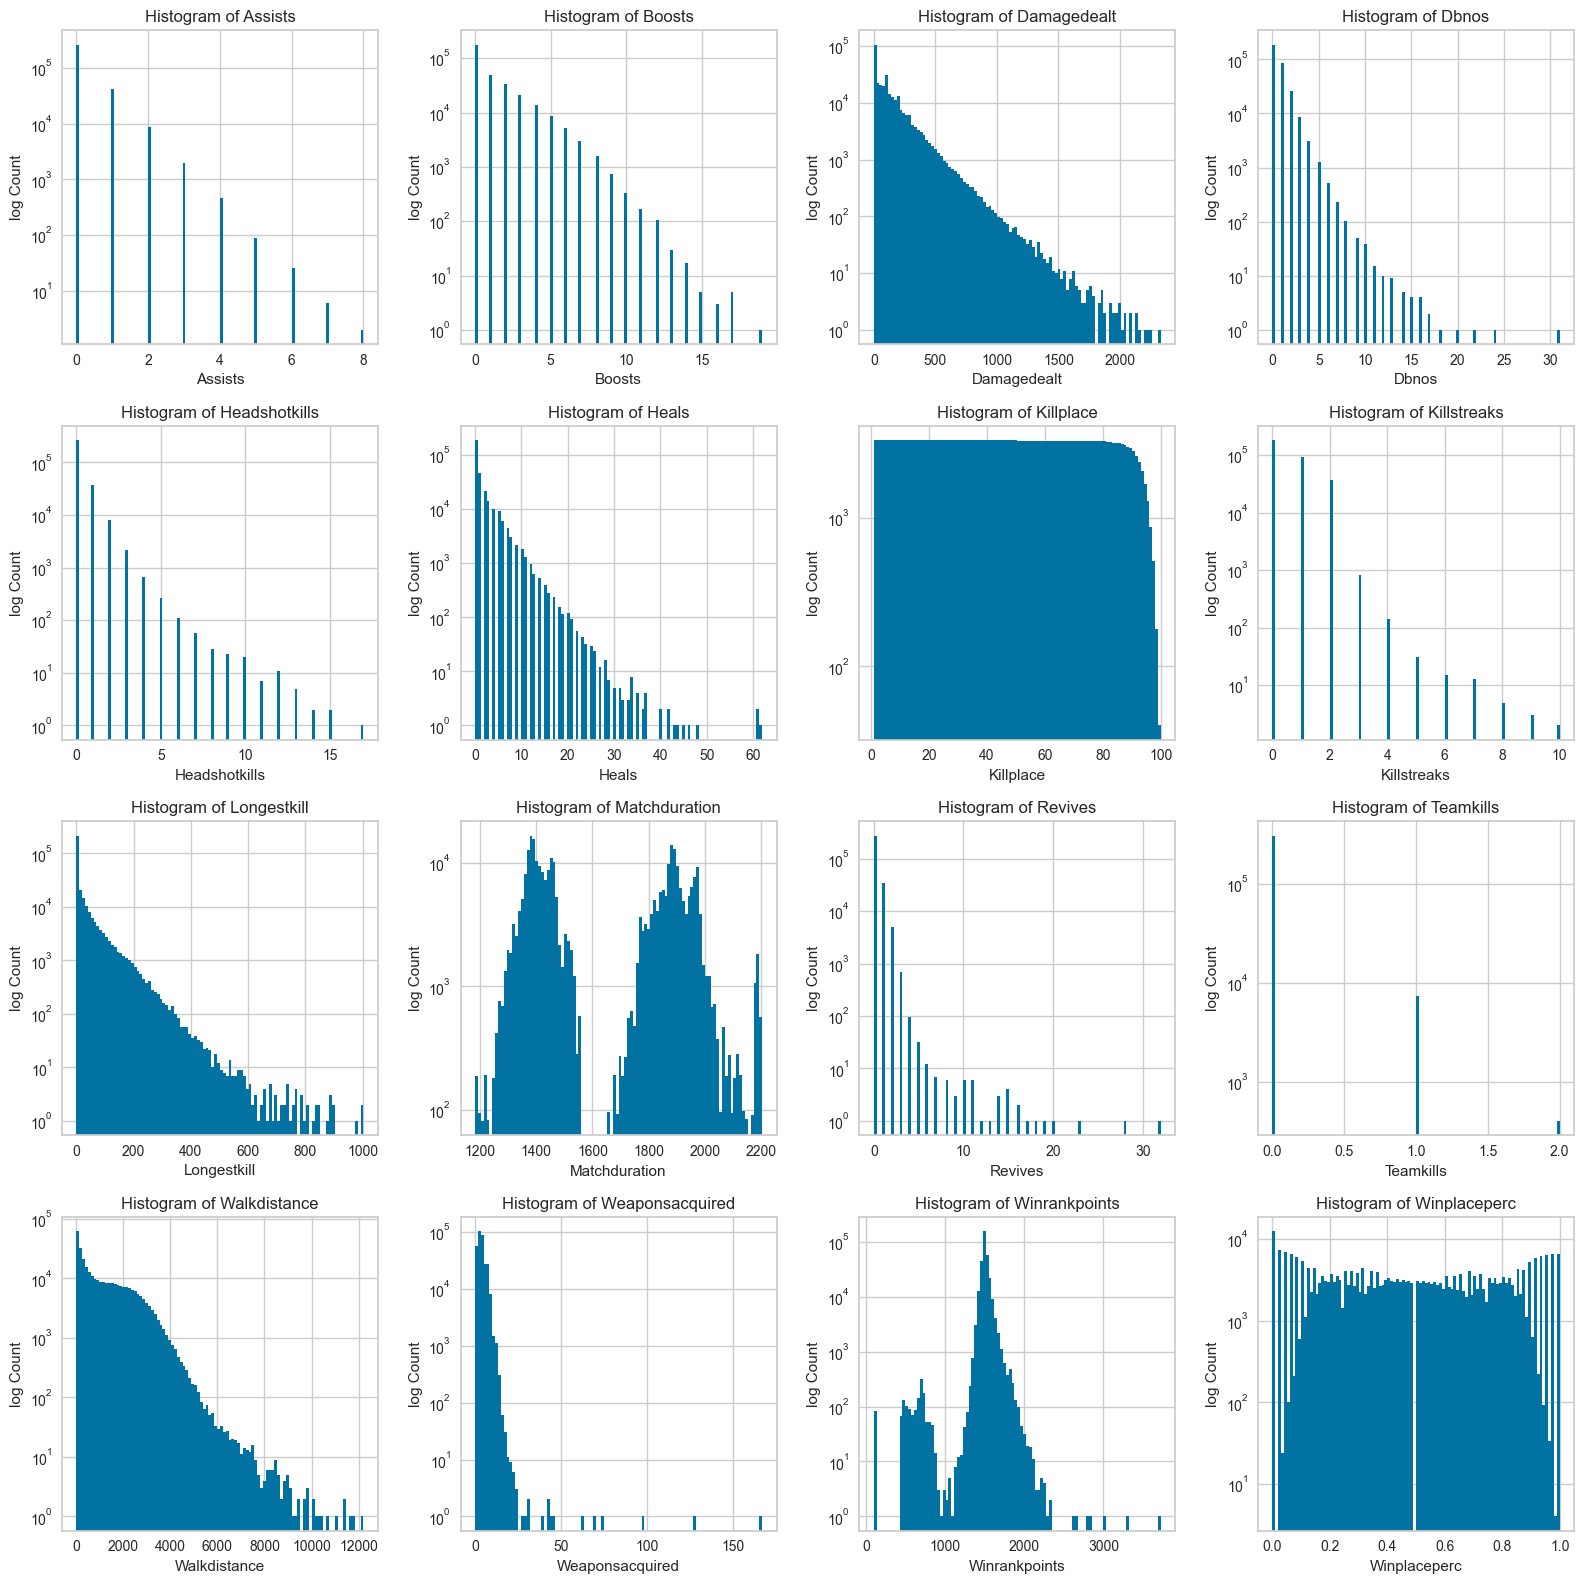

In [102]:
uf.draw_hist_all(pubgDF_duo, 100, "log")


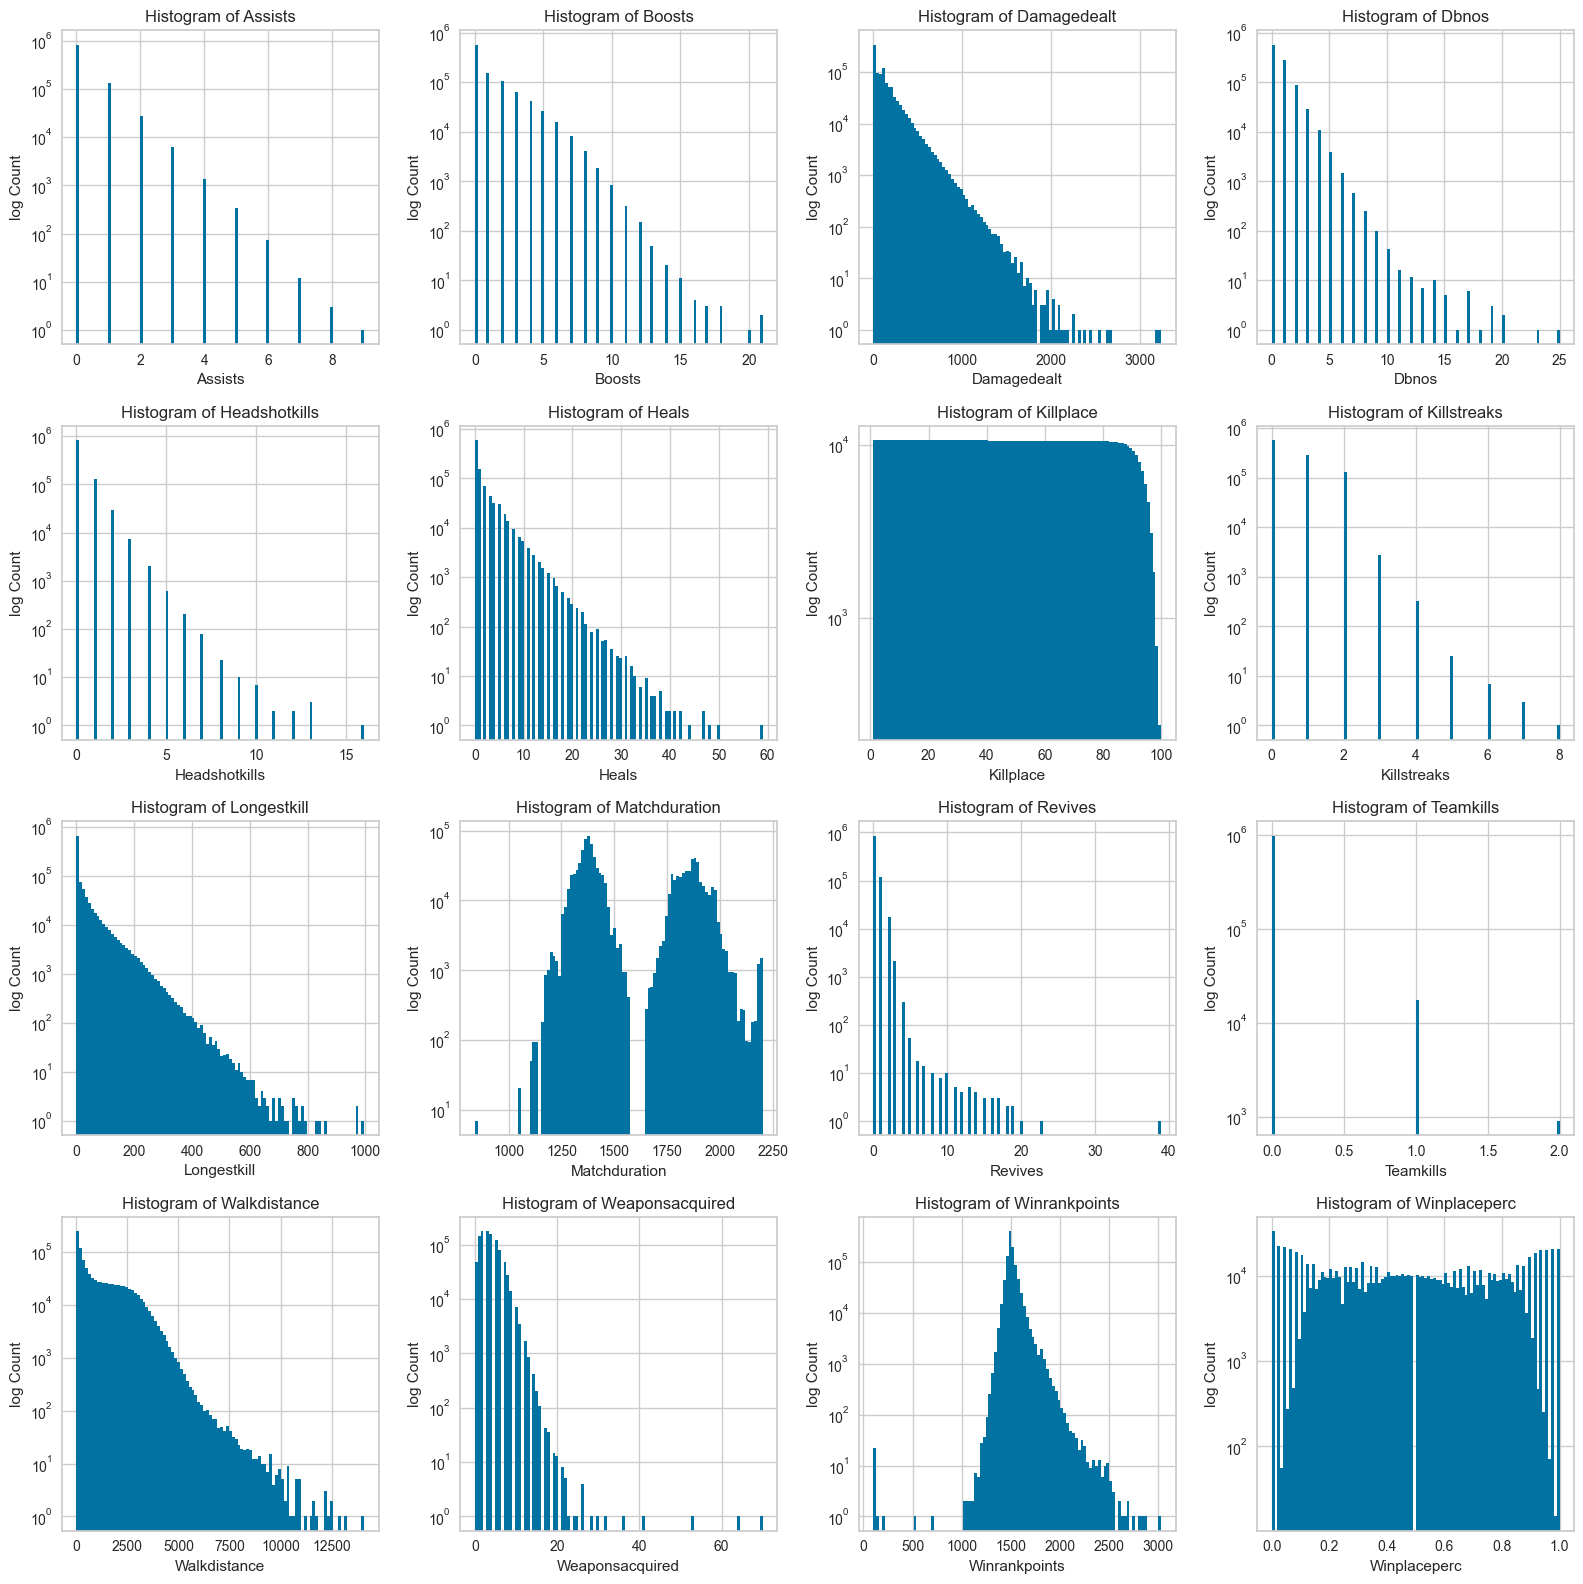

In [103]:
uf.draw_hist_all(pubgDF_duo_fpp, 100, "log")


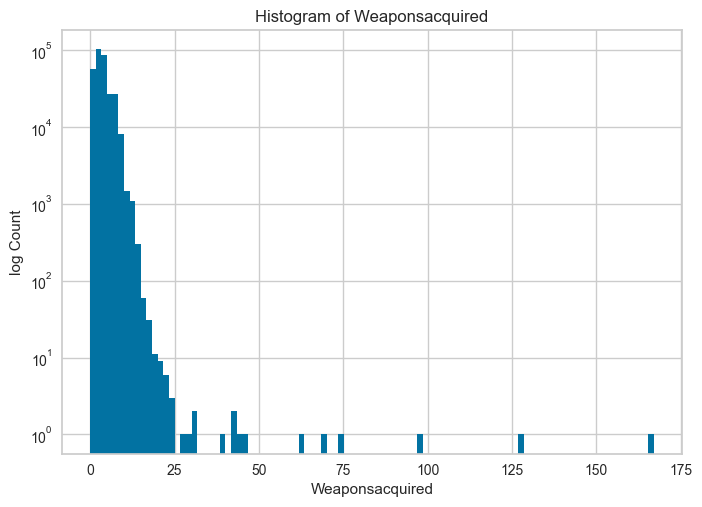

In [104]:
uf.draw_hist("weaponsAcquired", pubgDF_duo, 100, "log")


In [105]:
weaponsAcquired_mask = pubgDF_duo["weaponsAcquired"] < 25


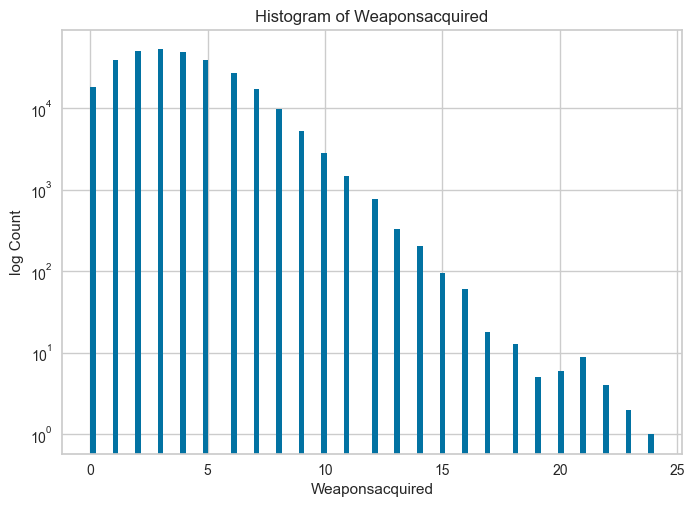

In [106]:
uf.draw_hist("weaponsAcquired", pubgDF_duo[weaponsAcquired_mask], 100, "log")


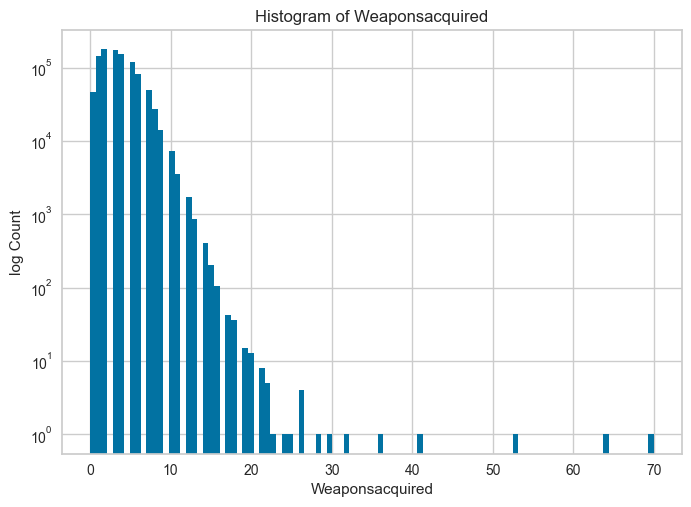

In [107]:
uf.draw_hist("weaponsAcquired", pubgDF_duo_fpp, 100, "log")


In [108]:
weaponsAcquired_mask_fpp = pubgDF_duo_fpp["weaponsAcquired"] < 25


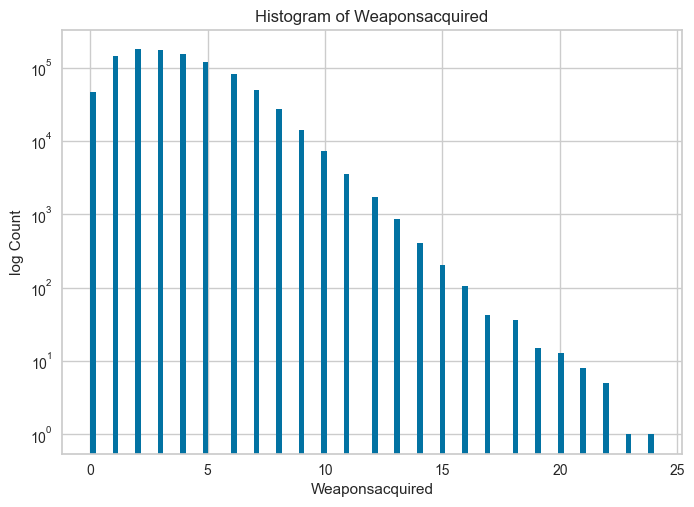

In [109]:
uf.draw_hist("weaponsAcquired", pubgDF_duo_fpp[weaponsAcquired_mask_fpp], 100, "log")


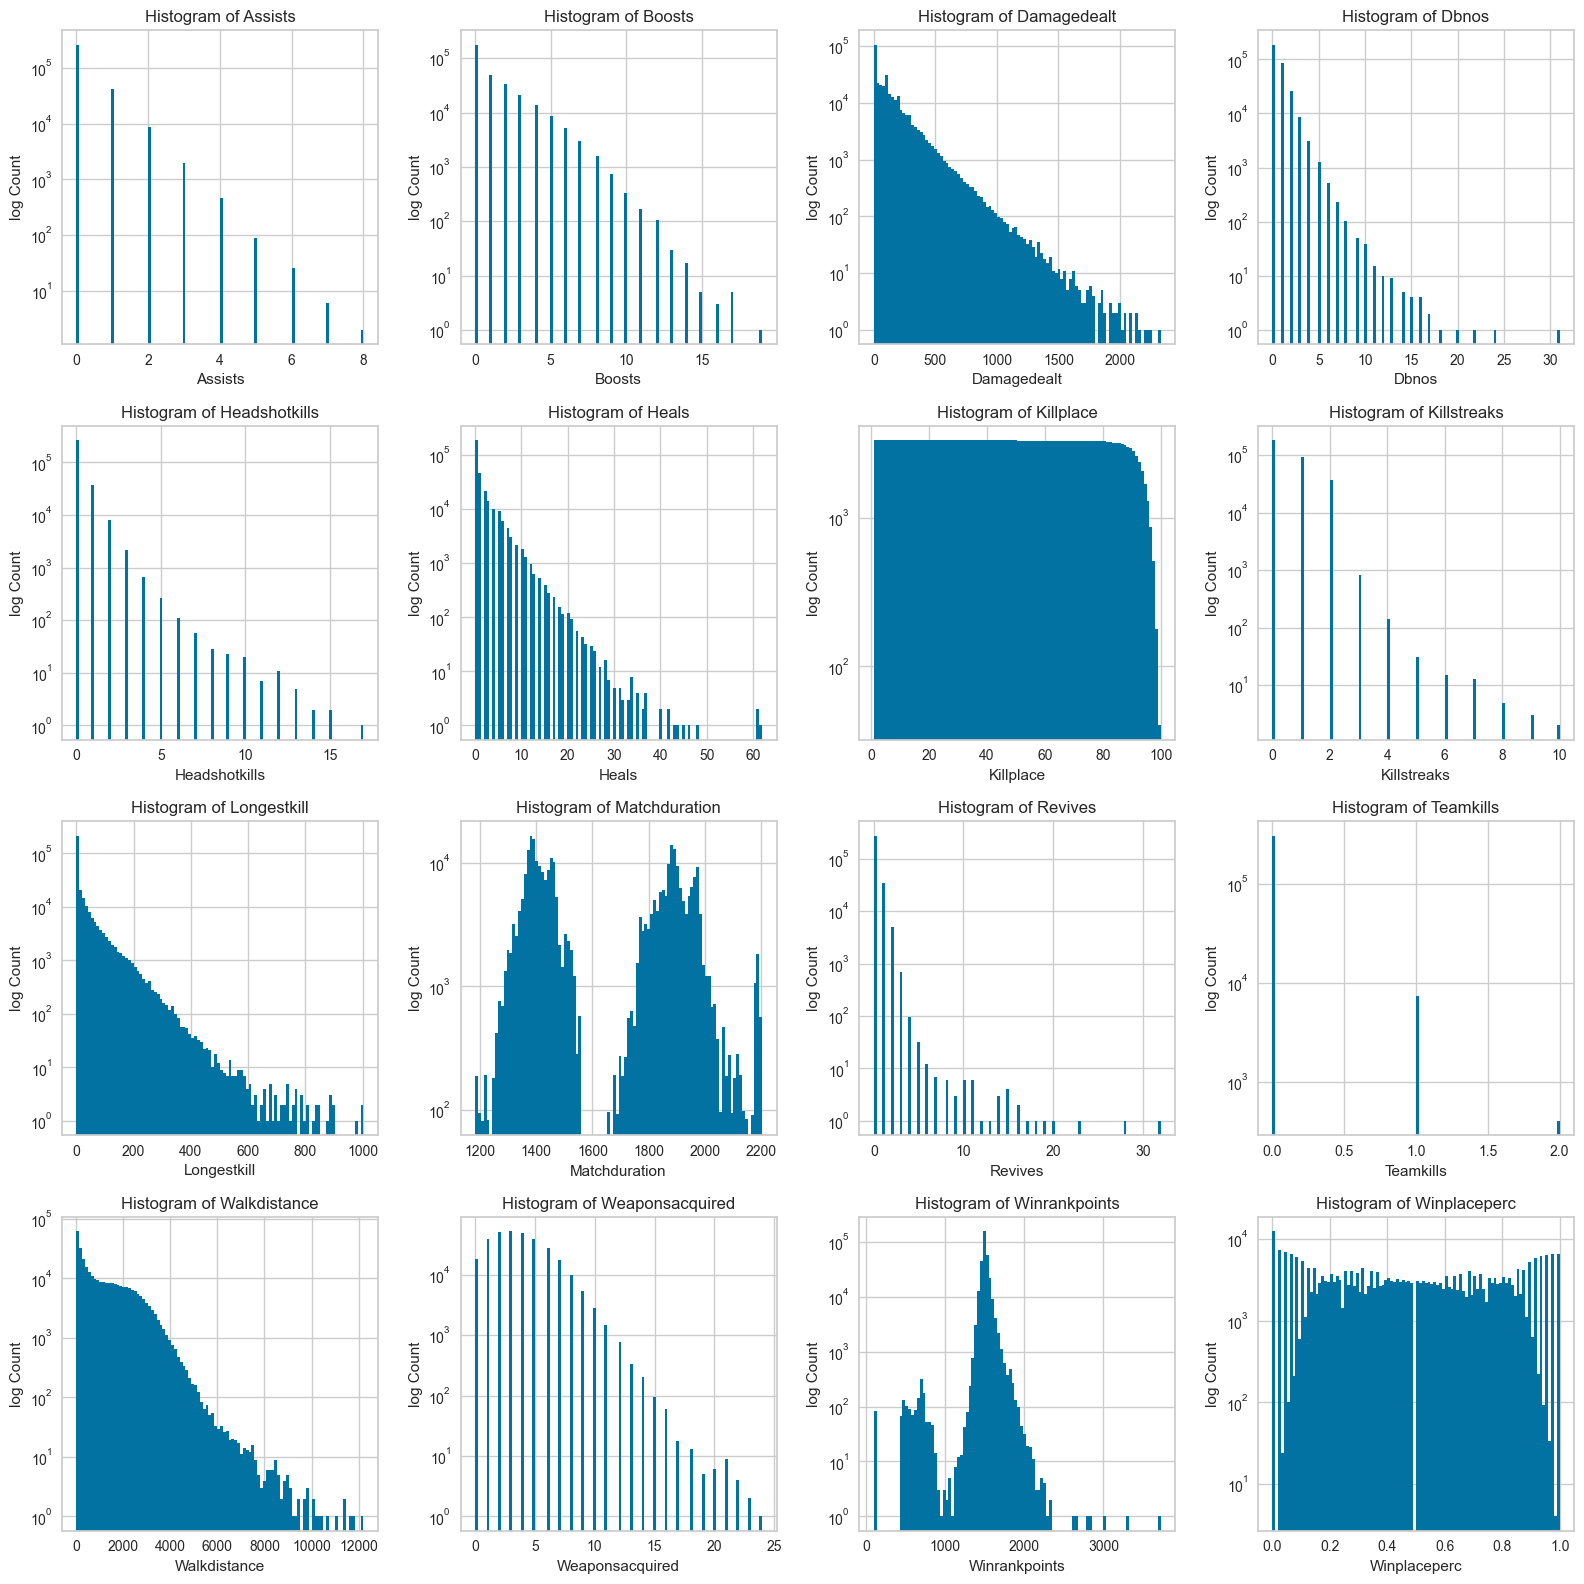

In [110]:
uf.draw_hist_all(pubgDF_duo[weaponsAcquired_mask], 100, "log")


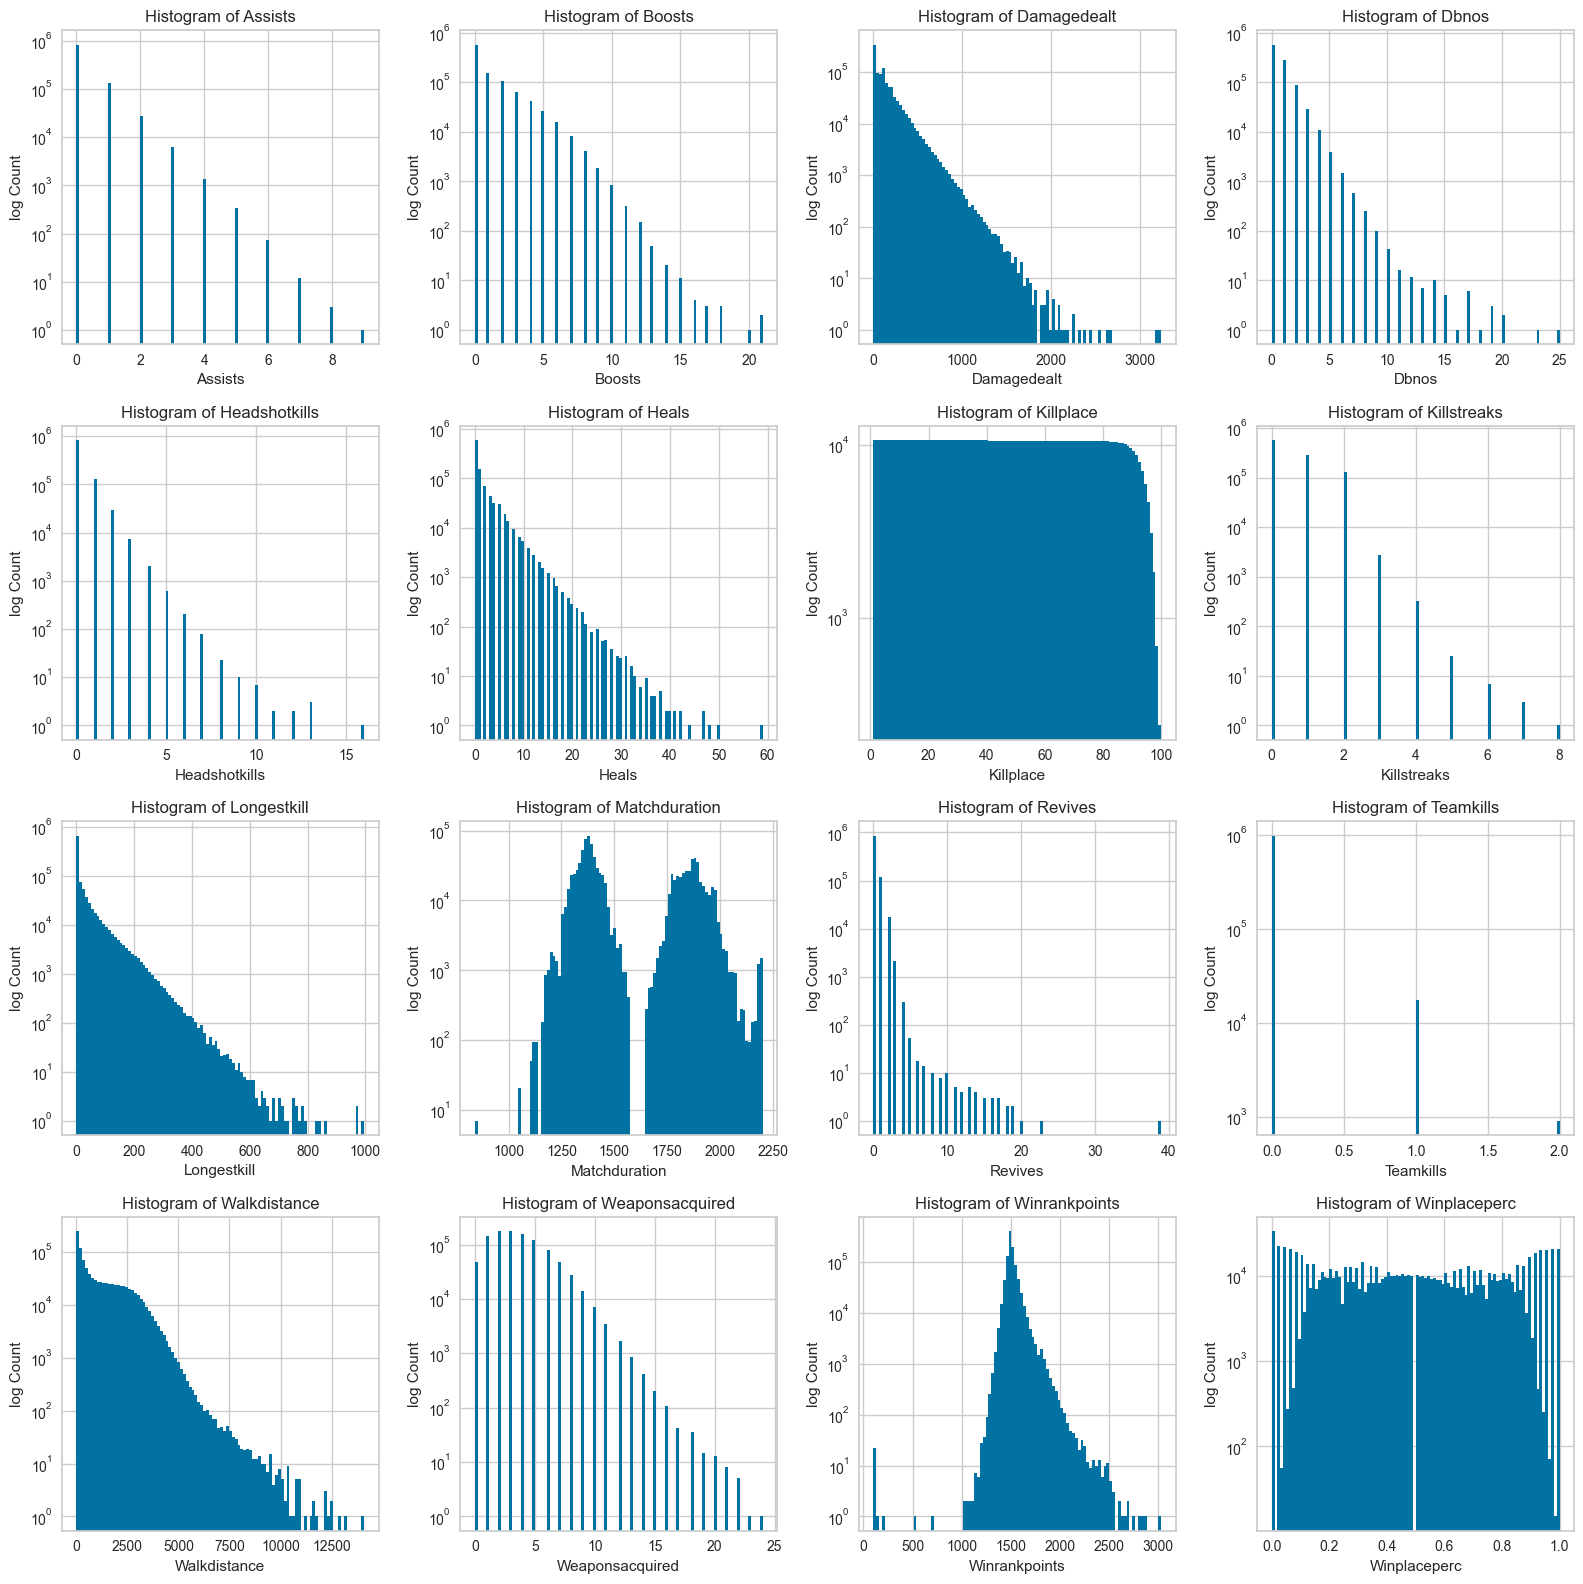

In [113]:
uf.draw_hist_all(pubgDF_duo_fpp[weaponsAcquired_mask_fpp], 100, "log")


In [114]:
pubgDF_duo_sample = pubgDF_duo[weaponsAcquired_mask].sample(n=12500)


In [115]:
featureDF = pubgDF_duo_sample.drop(["winPlacePerc"], axis=1)
targetSR = pubgDF_duo_sample["winPlacePerc"]


In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    featureDF, targetSR, test_size=0.2, random_state=42
)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(10000, 15) (10000,) (2500, 15) (2500,)


In [117]:
scalers = []
scalers.append(StandardScaler())
scalers.append(MinMaxScaler())
scalers.append(RobustScaler())


In [118]:
models = []
models.append(LinearRegression())
models.append(Lasso())
models.append(Ridge())
models.append(KNeighborsRegressor())
models.append(DecisionTreeRegressor())
models.append(RandomForestRegressor())


In [119]:
scoreDict = {}
i = 0
for scaler in scalers:
    for model in models:
        scaler.fit(X_train)
        scaled_X_train = scaler.transform(X_train)
        scale_X_test = scaler.transform(X_test)
        model.fit(scaled_X_train, y_train)
        train_score = model.score(scaled_X_train, y_train)
        test_score = model.score(scale_X_test, y_test)
        score_diff = abs(test_score - train_score)
        train_mae = mean_absolute_error(y_train, model.predict(scaled_X_train))
        test_mae = mean_absolute_error(y_test, model.predict(scale_X_test))
        mae_diff = abs(test_mae - train_mae)
        scoreDict[i] = {
            "scaler": scaler,
            "model": model,
            "train_score": train_score,
            "test_score": test_score,
            "score_diff": score_diff,
            "train_mae": train_mae,
            "test_mae": test_mae,
            "mae_diff": mae_diff,
        }
        i += 1
scoreDF = pd.DataFrame(scoreDict).T


In [122]:
scoreDF.sort_values(by=["test_mae", "mae_diff"], ascending=[True, True])


,scaler,model,train_score,test_score,score_diff,train_mae,test_mae,mae_diff
5,StandardScaler(),"(DecisionTreeRegressor(max_features=1.0, rando...",0.986484,0.901411,0.085073,0.024897,0.067388,0.042492
11,MinMaxScaler(),"(DecisionTreeRegressor(max_features=1.0, rando...",0.986556,0.901089,0.085467,0.024827,0.067543,0.042716
17,RobustScaler(),"(DecisionTreeRegressor(max_features=1.0, rando...",0.986509,0.899094,0.087416,0.024883,0.067806,0.042923
9,MinMaxScaler(),KNeighborsRegressor(),0.923965,0.878639,0.045327,0.06066,0.075173,0.014513
3,StandardScaler(),KNeighborsRegressor(),0.904382,0.844594,0.059788,0.068509,0.086514,0.018006
6,MinMaxScaler(),LinearRegression(),0.855048,0.845954,0.009094,0.085075,0.087238,0.002163
0,StandardScaler(),LinearRegression(),0.855048,0.845954,0.009094,0.085075,0.087238,0.002163
12,RobustScaler(),LinearRegression(),0.855048,0.845954,0.009094,0.085075,0.087238,0.002163
2,StandardScaler(),Ridge(),0.855048,0.845951,0.009098,0.085079,0.087242,0.002164
14,RobustScaler(),Ridge(),0.855048,0.845944,0.009104,0.085086,0.087251,0.002165


In [ ]:
auto_ml = pyr.setup(
    pubgDF_duo_sample,
    target="winPlacePerc",
    train_size=0.8,
    normalize=True,
    normalize_method="robust",
)


,Description,Value
0,Session id,1647
1,Target,winPlacePerc
2,Target type,Regression
3,Original data shape,"(12500, 16)"
4,Transformed data shape,"(12500, 16)"
5,Transformed train set shape,"(10000, 16)"
6,Transformed test set shape,"(2500, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_models = pyr.compare_models(sort="MAE", fold=5, n_select=10)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0663,0.0087,0.0934,0.9045,0.0624,0.2472,1.1260
lightgbm,Light Gradient Boosting Machine,0.0669,0.0089,0.0942,0.9028,0.0628,0.2492,0.1260
et,Extra Trees Regressor,0.0690,0.0094,0.0969,0.8972,0.0648,0.2599,0.5460
gbr,Gradient Boosting Regressor,0.0696,0.0094,0.0967,0.8977,0.0642,0.2625,0.3080
xgboost,Extreme Gradient Boosting,0.0698,0.0097,0.0984,0.8941,0.0656,0.2576,0.0640
rf,Random Forest Regressor,0.0698,0.0098,0.0989,0.8930,0.0658,0.2563,0.8820
huber,Huber Regressor,0.0878,0.0143,0.1194,0.8440,0.0786,0.3591,0.0340
ridge,Ridge Regression,0.0882,0.0142,0.1192,0.8444,0.0788,0.3682,0.0140
br,Bayesian Ridge,0.0882,0.0142,0.1192,0.8444,0.0788,0.3682,0.0160
lr,Linear Regression,0.0882,0.0142,0.1192,0.8444,0.0788,0.3679,0.0180


In [124]:
best_scoreDict = {}
for i in range(5):
    best_models[i].fit(X_train, y_train)
    cat_train_score = best_models[i].score(X_train, y_train)
    cat_test_score = best_models[i].score(X_test, y_test)
    cat_train_mae = mean_absolute_error(y_train, best_models[i].predict(X_train))
    cat_test_mae = mean_absolute_error(y_test, best_models[i].predict(X_test))
    best_scoreDict[i] = {
        "model": best_models[i],
        "train_score": cat_train_score,
        "test_score": cat_test_score,
        "score_diff": abs(cat_test_score - cat_train_score),
        "train_mae": cat_train_mae,
        "test_mae": cat_test_mae,
        "mae_diff": abs(cat_test_mae - cat_train_mae),
    }
best_scoreDF = pd.DataFrame(best_scoreDict).T


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 15
[LightGBM] [Info] Start training from score 0.483961


In [125]:
best_scoreDF.sort_values(by=["test_mae", "mae_diff"], ascending=[True, True])


,model,train_score,test_score,score_diff,train_mae,test_mae,mae_diff
0,<catboost.core.CatBoostRegressor object at 0x0...,0.947851,0.911345,0.036506,0.051029,0.064287,0.013258
1,"LGBMRegressor(n_jobs=-1, random_state=1647)",0.941499,0.90662,0.034879,0.053828,0.065626,0.011798
4,"XGBRegressor(base_score=None, booster='gbtree'...",0.969245,0.903918,0.065327,0.038965,0.066929,0.027964
3,([DecisionTreeRegressor(criterion='friedman_ms...,0.914521,0.902591,0.01193,0.063988,0.067783,0.003795
2,"(ExtraTreeRegressor(random_state=435524972), E...",1.0,0.898756,0.101244,0.0,0.068437,0.068437


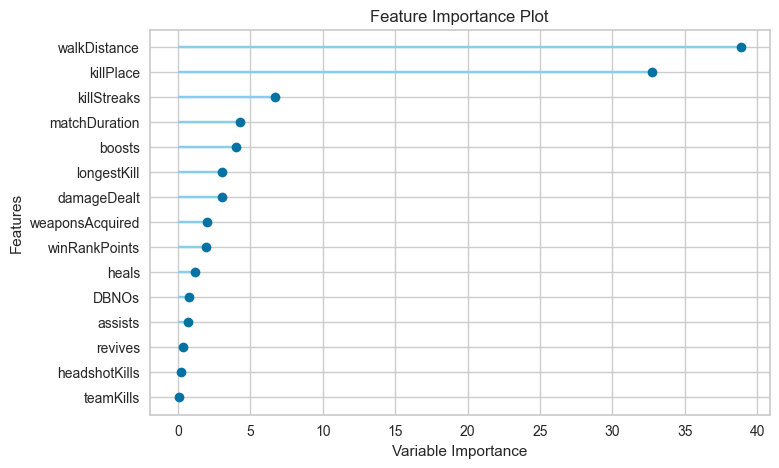

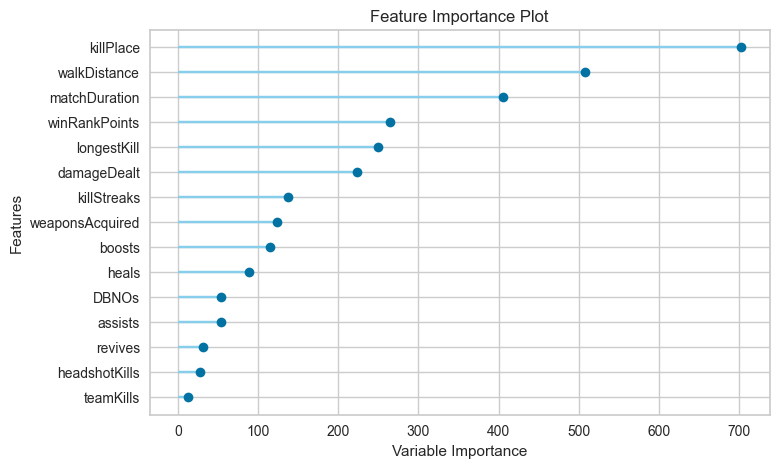

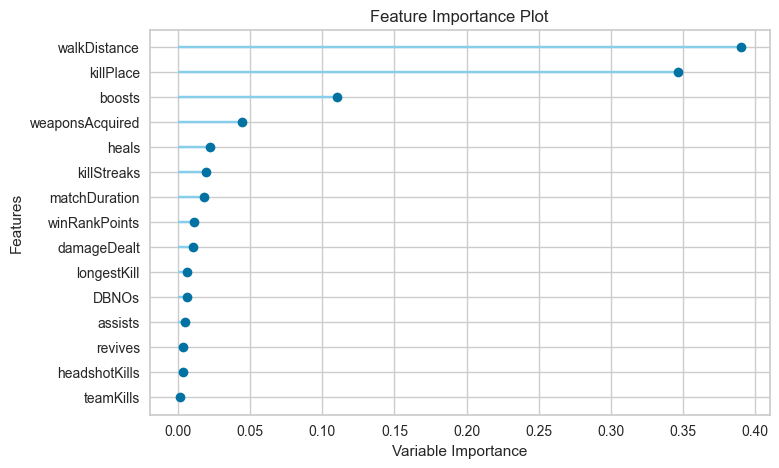

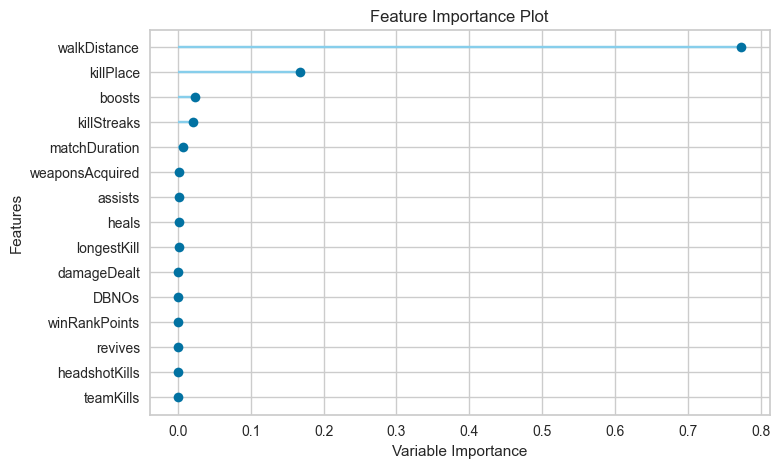

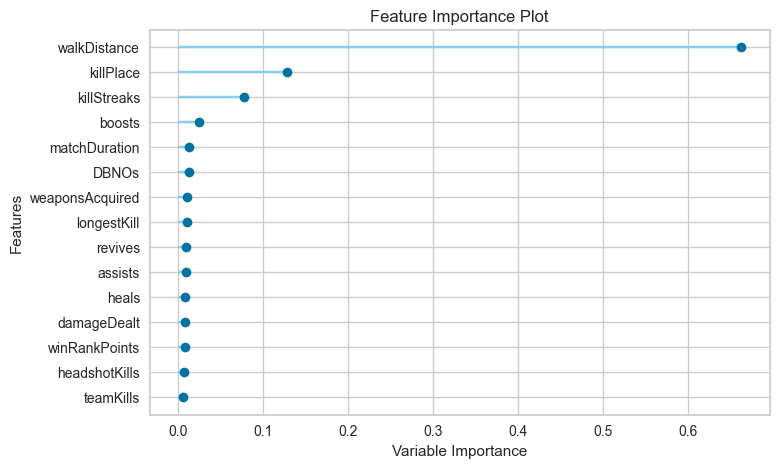

In [ ]:
for i in range(5):
    pyr.plot_model(best_models[i], plot="feature_all")
